In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pubchempy
import pandas as pd
from itertools import compress
import seaborn as sns
from matchms.importing import load_from_mgf

from rdkit import Chem
from rdkit.Chem import Draw


from matchms import calculate_scores
from matchms.plotting.spectrum_plots import plot_spectra_mirror, plot_spectrum


from matplotlib import animation, rc
from celluloid import Camera # getting the camera
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

from SpectralPerturbation import perturb_spetrum_copy, perturb_spectral_list

from matchms import calculate_scores
from matchms.similarity import CosineGreedy
from matchms.similarity import ModifiedCosine
import random

import matchms
matchms.logging_functions.set_matchms_logger_level("ERROR")

random.seed(42)
np.random.seed(42)


In [2]:
path_data = "../data"

print("Load reference and query data.")
file_mgf_reference = os.path.join(path_data, "ex_spectra_stds_NEG_scans_50.mgf")
reference_spectra = list(load_from_mgf(file_mgf_reference))

file_mgf_query = os.path.join(path_data, "pseudo_query_neg_v1.mgf")
query_spectra = list(load_from_mgf(file_mgf_query))

print(f"Detected {len(reference_spectra)} reference spectra and {len(query_spectra)} query spectra.")

Load reference and query data.
Detected 968 reference spectra and 1614 query spectra.


<AxesSubplot: title={'center': 'Spectrum'}, xlabel='m/z', ylabel='Intensity'>

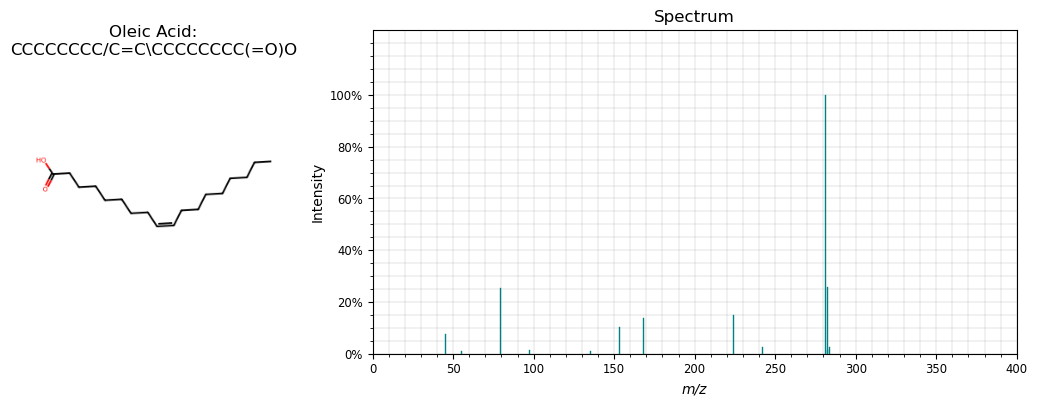

In [3]:
example_query_number = 1394
example_spectrum = query_spectra[example_query_number]
example_smiles = "CCCCCCCC/C=C\CCCCCCCC(=O)O"

fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.2), gridspec_kw={'width_ratios': [2, 5]}, sharey=False)


# Compound
img = Chem.Draw.MolToImage(Chem.MolFromSmiles(example_smiles), ax=axs[0])

axs[0].grid(False)
axs[0].tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False)
axs[0].set_title("Oleic Acid:\n" + example_smiles)
axs[0].imshow(img)
axs[0].axis("off")

# Spectrum
plot_spectrum(example_spectrum, axs[1])

### Perturbation to peak intenity

Now, let's add some random perturbation to all peaks. The implementation of the perturbation follows Toprak *et. al.* (2014) with perturbation strength *r*, which randomnly sampled from a specified perturbation range, e.g. 0.25 to 0.5. This effect of the perturbations are shown below.


In [4]:
TOLERANCE = 0.005
similarity_measure = CosineGreedy(tolerance=TOLERANCE)

In [5]:
%%capture

fig, ax = plt.subplots(1, 1, figsize=(12.8, 4.2))
perturb_range = [0.25, 0.5]



# Spectrum animation
camera = Camera(fig)# the camera gets our figure

# Original spectrum
plot_spectrum(example_spectrum, ax)
ax.text(1, 1.2, f"Original spectrum") # Dynamic subtext

camera.snap()

for i in range(9):
    # Create perturbed copy of the spectrum
    spectrum = perturb_spetrum_copy(example_spectrum, perturb_range)
    
    # 
    cosine_scores = calculate_scores([example_spectrum], [spectrum], similarity_measure, is_symmetric=False)
    match = cosine_scores.scores_by_query(spectrum, sort=True)[0][1]
    cosine = match.tolist()[0]
        
    plot_spectrum(spectrum, ax)
    #ax.text(1, 1.2, f"Perturbation Level: {perturb_range[0] * 100}% to {perturb_range[1] * 100}%")
    ax.text(1, 1.2, f"Cosine similarity: {cosine:.2f}")

    plt.title(f"Effect of a moderate level of peak ({perturb_range[0] * 100}% to {perturb_range[1] * 100}%)")
    camera.snap()

animation = camera.animate(blit=False, interval=600)
rc('animation', html='html5')

In [6]:
#HTML(animation.to_html5_video())
animation.save('../img/spectrum_moderate_perturbation.gif')

![GIF](../img/spectrum_moderate_perturbation.gif "segment")


Let's crank up the perturbation


In [7]:
%%capture

fig, ax = plt.subplots(1, 1, figsize=(12.8, 4.2))
perturb_range = [0.5, 0.75]



# Spectrum animation
camera = Camera(fig)# the camera gets our figure

# Original spectrum
plot_spectrum(example_spectrum, ax)
ax.text(1, 1.2, f"Original spectrum") # Dynamic subtext

camera.snap()

for i in range(9):
    # Create perturbed copy of the spectrum
    spectrum = perturb_spetrum_copy(example_spectrum, perturb_range)
    
    # 
    cosine_scores = calculate_scores([example_spectrum], [spectrum], similarity_measure, is_symmetric=False)
    match = cosine_scores.scores_by_query(spectrum, sort=True)[0][1]
    cosine = match.tolist()[0]
        
    plot_spectrum(spectrum, ax)
    #ax.text(1, 1.2, f"Perturbation Level: {perturb_range[0] * 100}% to {perturb_range[1] * 100}%")
    ax.text(1, 1.2, f"Cosine similarity: {cosine:.2f}")

    plt.title(f"Effect of a high level of peak ({perturb_range[0] * 100}% to {perturb_range[1] * 100}%)")
    camera.snap()

animation = camera.animate(blit=False, interval=600)
rc('animation', html='html5')

In [8]:
#TML(animation.to_html5_video())
animation.save('../img/spectrum_high_perturbation.gif')

![GIF](../img/spectrum_high_perturbation.gif "segment")

### Investigating the scores of perturbed spectra

In [9]:
TOLERANCE = 0.005
similarity_measure = CosineGreedy(tolerance=TOLERANCE)
cosine_scores = calculate_scores(query_spectra, query_spectra, similarity_measure, is_symmetric=True)

In [10]:
cosine_scores.scores[example_query_number, example_query_number]["score"]

1.0

Text(0.5, 0, 'Query spectrum #ID')

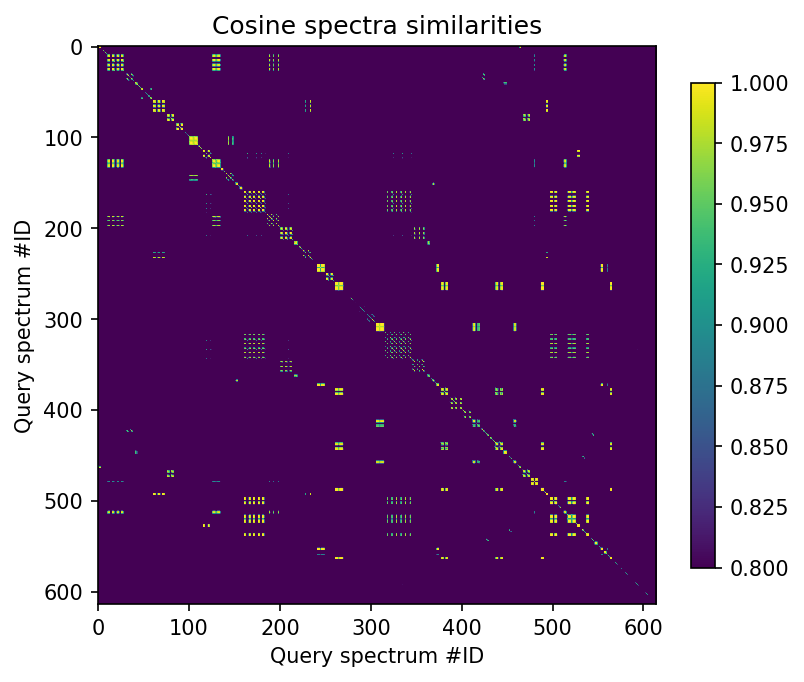

In [11]:
plt.figure(figsize=(6,6), dpi=150)
plt.imshow(cosine_scores.scores[1000:, 1000:]["score"], cmap="viridis", vmin=0.8, vmax=1)
plt.colorbar(shrink=0.7)
plt.title("Cosine spectra similarities")
plt.ylabel("Query spectrum #ID")
plt.xlabel("Query spectrum #ID")

In [12]:
perturbed_query_spectra = perturb_spectral_list(query_spectra, [0.5, 0.75])
cosine_scores_1 = calculate_scores(query_spectra, perturbed_query_spectra, similarity_measure, is_symmetric=True)

Text(0.5, 0, 'Query spectrum #ID')

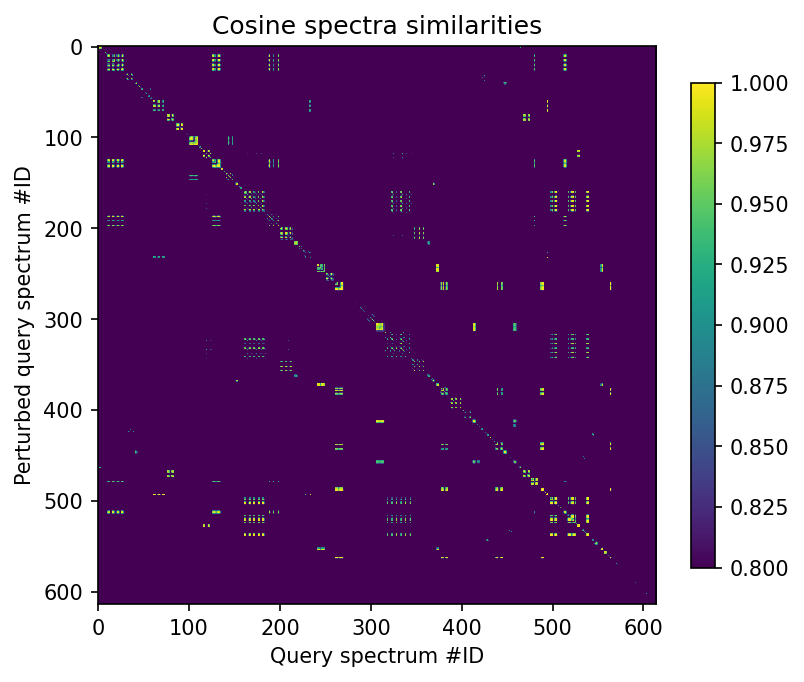

In [13]:
plt.figure(figsize=(6,6), dpi=150)
plt.imshow(cosine_scores_1.scores[1000:, 1000:]["score"], cmap="viridis", vmin=0.8, vmax=1)
plt.colorbar(shrink=0.7)
plt.title("Cosine spectra similarities")
plt.ylabel("Perturbed query spectrum #ID")
plt.xlabel("Query spectrum #ID")

In [14]:
cosine_scores_1.scores[example_query_number + 2, example_query_number + 2]["score"]

0.8596704328630658

<AxesSubplot: xlabel='variable', ylabel='value'>

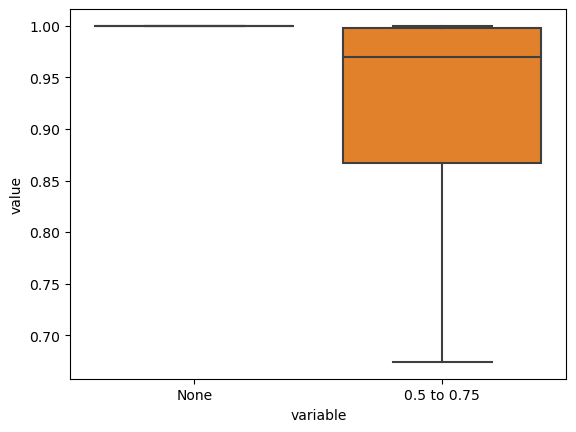

In [15]:
diag_scores =  np.vectorize(lambda x: x[0])(np.diagonal(cosine_scores.scores))
diag_scores_1 =  np.vectorize(lambda x: x[0])(np.diagonal(cosine_scores_1.scores))

#diag_matches = pd.DataFrame({'scores': np.concatenate([diag_scores, diag_scores_1]), 'perturb': ["None" for i in range(len(diag_scores))] + ["0.5 to 0.75" for i in range(len(diag_scores_1))]})
#print(diag_matches.tail())

diag_matches = pd.DataFrame({'None': diag_scores, '0.5 to 0.75': diag_scores_1})

melting_pot = pd.melt(diag_matches)

sns.boxplot(data=melting_pot, y="value", x="variable")#, hue="perturb")

In [16]:
ALL_SCORES = {}
ALL_DIAG = {}

ranges =[0, 0.25, 0.5, 0.75, 1]

for i in range(len(ranges) - 1):
    perturb_range = [ranges[i], ranges[i + 1]]
    print("Calculating perturbations and scores for range: ", perturb_range)
    
    perturbed_query_spectra = perturb_spectral_list(query_spectra, perturb_range)
    cosine_scores = calculate_scores(query_spectra, perturbed_query_spectra, similarity_measure, is_symmetric=True)

    ALL_SCORES[f'{perturb_range[0]} to {perturb_range[1]}'] = cosine_scores.scores
    ALL_DIAG[f'{perturb_range[0]} to {perturb_range[1]}'] = np.vectorize(lambda x: x[0])(np.diagonal(cosine_scores.scores))
    
    

Calculating perturbations and scores for range:  [0, 0.25]
Calculating perturbations and scores for range:  [0.25, 0.5]
Calculating perturbations and scores for range:  [0.5, 0.75]
Calculating perturbations and scores for range:  [0.75, 1]


In [17]:
color_palette = sns.color_palette("YlOrBr", 6)
default_color = color_palette[-1]

(0.0, 1.02)

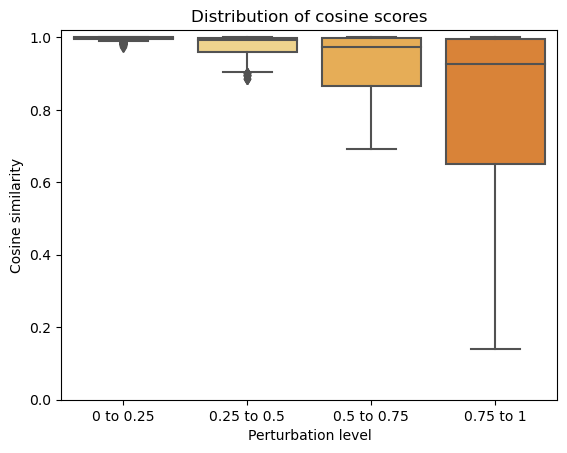

In [18]:
melting_pot_cos = pd.DataFrame(ALL_DIAG).melt()


sns.boxplot(data=melting_pot_cos, y="value", x="variable", palette=color_palette)#, hue="perturb")
plt.title("Distribution of cosine scores")
plt.xlabel("Perturbation level")
plt.ylabel("Cosine similarity")
plt.ylim([0, 1.02])

Square root transformed peak intensities

In [19]:
TOLERANCE = 0.005
similarity_measure = CosineGreedy(tolerance=TOLERANCE, intensity_power=0.5)

In [20]:
ALL_SCORES = {}
ALL_DIAG = {}

ranges =[0, 0.25, 0.5, 0.75, 1]

for i in range(len(ranges) - 1):
    perturb_range = [ranges[i], ranges[i + 1]]
    print("Calculating perturbations and scores for range: ", perturb_range)
    
    perturbed_query_spectra = perturb_spectral_list(query_spectra, perturb_range)
    cosine_scores = calculate_scores(query_spectra, perturbed_query_spectra, similarity_measure, is_symmetric=True)

    ALL_SCORES[f'{perturb_range[0]} to {perturb_range[1]}'] = cosine_scores.scores
    ALL_DIAG[f'{perturb_range[0]} to {perturb_range[1]}'] = np.vectorize(lambda x: x[0])(np.diagonal(cosine_scores.scores))
    
    

Calculating perturbations and scores for range:  [0, 0.25]
Calculating perturbations and scores for range:  [0.25, 0.5]
Calculating perturbations and scores for range:  [0.5, 0.75]
Calculating perturbations and scores for range:  [0.75, 1]


(0.0, 1.02)

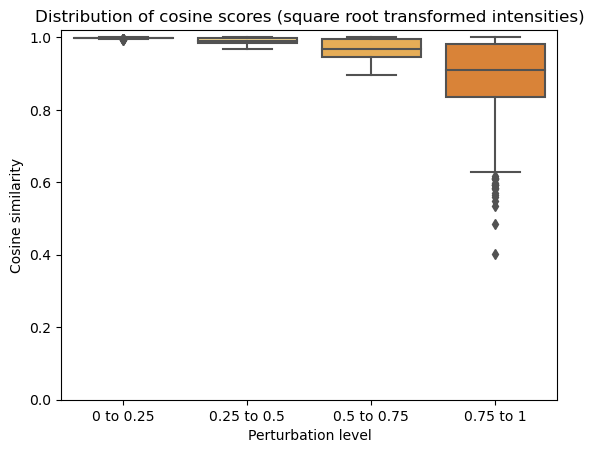

In [21]:
melting_pot_cos_root = pd.DataFrame(ALL_DIAG).melt()


sns.boxplot(data=melting_pot_cos_root, y="value", x="variable", palette=color_palette)#, hue="perturb")
plt.title("Distribution of cosine scores (square root transformed intensities)")
plt.xlabel("Perturbation level")
plt.ylabel("Cosine similarity")
plt.ylim([0, 1.02])

Text(0, 0.5, '')

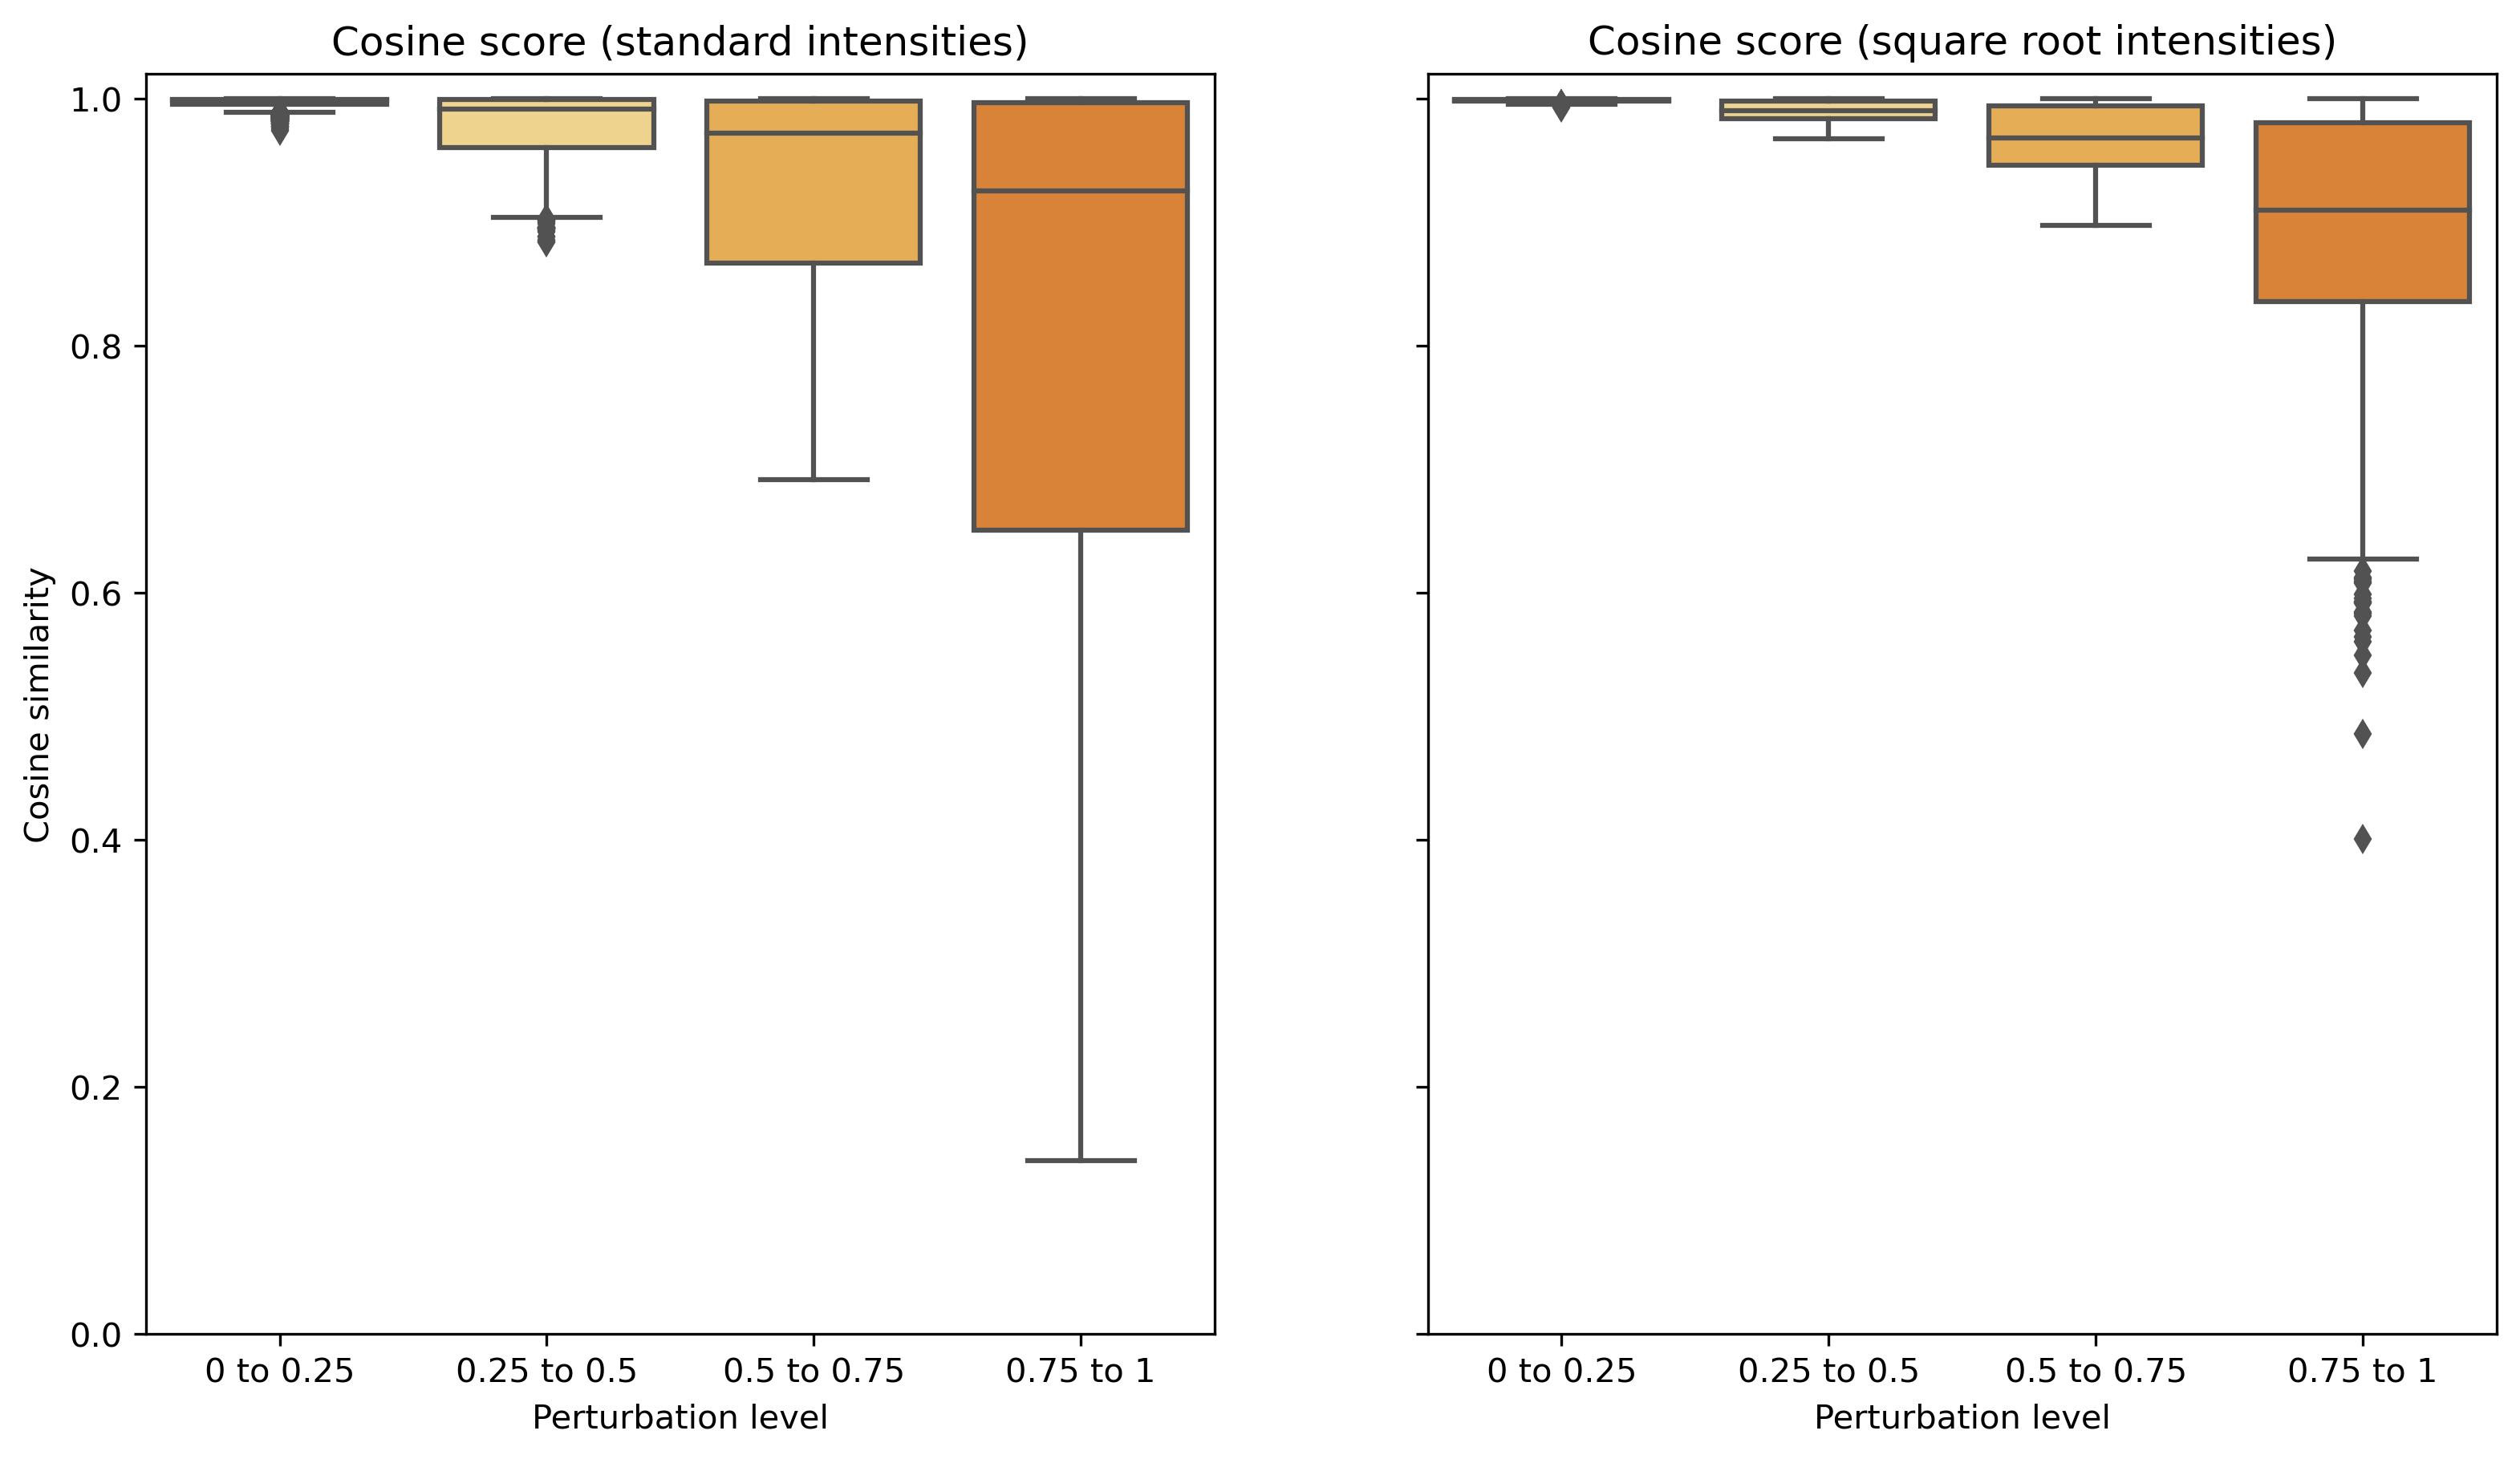

In [23]:
fig, axs = plt.subplots(1,2, figsize=(12.6, 6.8), dpi=300, sharey=True)


sns.boxplot(ax=axs[0], data=melting_pot_cos, y="value", x="variable", palette=color_palette)
axs[0].set_title("Cosine score (standard intensities)")
axs[0].set_xlabel("Perturbation level")
axs[0].set_ylabel("Cosine similarity")
axs[0].set_ylim([0, 1.02])

sns.boxplot(ax=axs[1], data=melting_pot_cos_root, y="value", x="variable", palette=color_palette)
axs[1].set_title("Cosine score (square root intensities)")
axs[1].set_xlabel("Perturbation level")
axs[1].set_ylabel("")

